In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mdtraj as md

In [2]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
# import tidynamics as td

## Load and inspect the data

In [3]:
traj = md.load('data/water_nojump_3.xtc',top= 'data/water_top.pdb')
com = md.compute_center_of_mass(traj)
com.shape

/Users/robertarbon/miniconda3/envs/science/lib/python3.6/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.6, you have 2.5.5.
  .format(latest=latest, current=current), category=UserWarning)


(10000001, 3)

In [4]:
traj.timestep

0.1

In [5]:
df = pd.DataFrame(com, columns=['x', 'y', 'z'])
df['t'] = traj.time/1000

df_melt = pd.melt(frame=df, id_vars=['t'], value_vars=['x', 'y', 'z'], var_name='coord', )

df_melt.head()

,t,coord,value
0,0.0000,x,2.322035
1,0.0001,x,2.317498
2,0.0002,x,2.348874
3,0.0003,x,2.367788
4,0.0004,x,2.341420


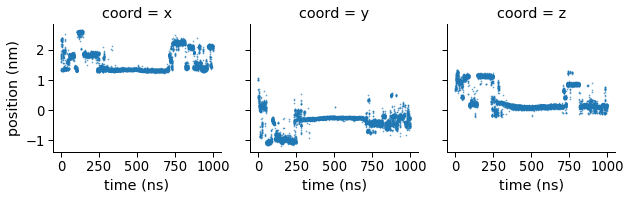

In [81]:
with sns.plotting_context('paper', font_scale=1.5):
    g = sns.FacetGrid(df_melt.iloc[::1000,:], col='coord')
    g.map(plt.scatter, 't', 'value', alpha=0.5, s=1)
    g.set_axis_labels('time (ns)', 'position (nm)')
    plt.savefig('thesis chapter/traj_3_xyz.png', bbox_inches='tight')

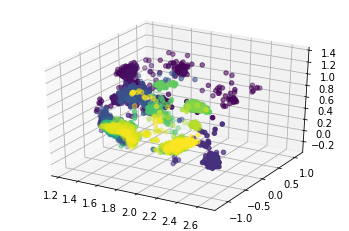

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(xs=com[::1000,0], ys=com[::1000,1], zs=com[::1000,2], c=df['t'][::1000])

In [1]:
## VAMP

## TICA whole traj

### Split data into 1ns pieces

This is because we have a wide variety of behaviour across the trajectory and we only want to focus on small chunks at a time. 

In [9]:
dt_ps = traj.timestep
dt_ns = dt_ps/1000 # in ns
window = 1 # window size in ns
n_frames = int(window/dt) # number of frames in a window
n_splits = com.shape[0]//n_frames # number of windows in trajectory
traj_split = np.array_split(com, n_splits) # the split up 

## Choose TICA lag time



In [78]:
np.random.seed(42)
tica_lags = (np.logspace(0, np.log10(50), 10)).astype(int)
idxs = np.random.choice(np.arange(n_splits), size=10, replace=False)
tss = {'t2': [coor.tica(traj_split[idx], lag=int(lag/dt_ps), dim=3,  kinetic_map=True).timescales[0]*dt_ps 
              for lag in tica_lags for idx in idxs], 
       'idx': [idx for lag in tica_lags for idx in idxs], 
       'lag': [lag for lag in tica_lags for idx in idxs]}
       

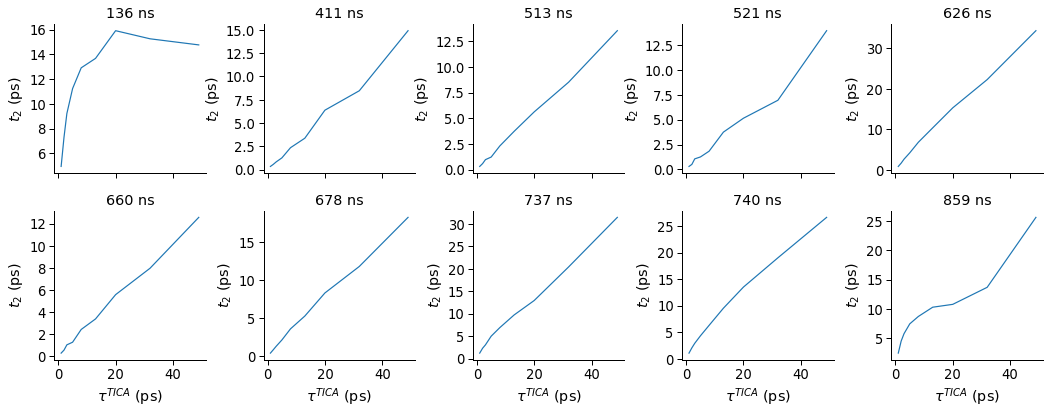

In [80]:
df_tica = pd.DataFrame(tss)
df_tica['t2_norm'] = df_tica.groupby('idx')['t2'].transform(lambda x: x/np.min(x))
df_tica.rename(columns={'lag': r'$\tau^{TICA}$ (ps)'}, inplace=True)
with sns.plotting_context('paper', font_scale=1.5):
    g = sns.FacetGrid(df_tica, col='idx', col_wrap=5, sharey=False)
    g.map(plt.plot, r'$\tau^{TICA}$ (ps)', 't2')
    g.set(ylabel=r'$t_{2}$ (ps)')
    g.set_titles('{col_name} ns')
    plt.savefig('thesis chapter/traj_3_tica_lags.png', bbox_inches='tight')

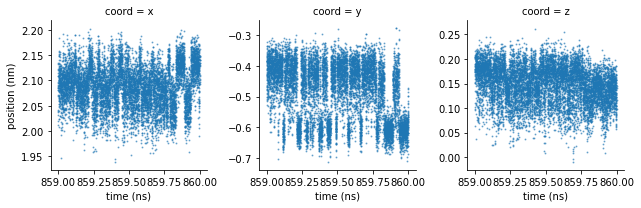

In [72]:
i = 859
delta = 1
g = sns.FacetGrid(df_melt.query('(t<{}) & (t>={})'.format(i+delta, i)), col='coord', sharey=False)
g.map(plt.scatter, 't', 'value', alpha=0.5, s=1)
g.set_axis_labels('time (ns)', 'position (nm)')

In [146]:
tica_lag = int(20/dt_ps)
tica_trajs = [coor.tica(traj, lag=tica_lag, dim=1,  kinetic_map=True).get_output()[0].flatten() 
              for traj in traj_split]


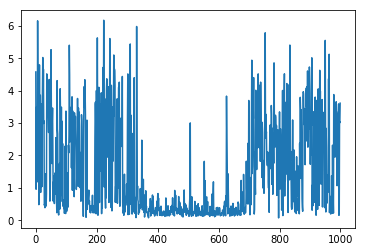

In [147]:
extents = [np.max(traj)-np.min(traj) for traj in tica_trajs]
plt.plot(extents)

In [148]:
from matplotlib.ticker import FixedLocator, FixedFormatter

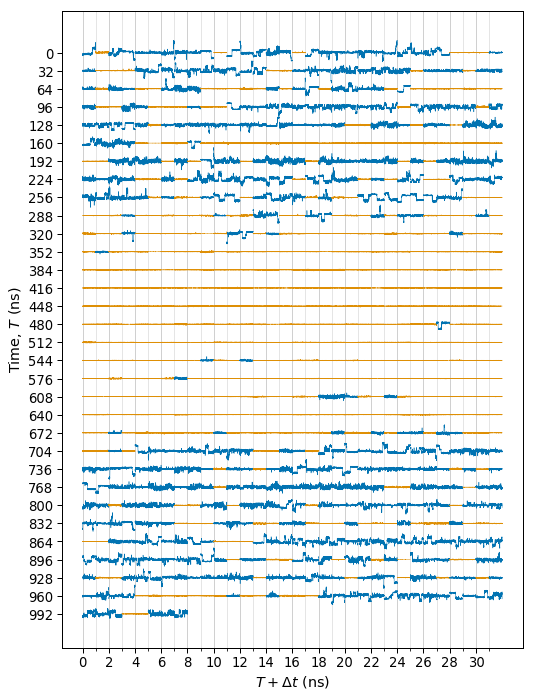

In [150]:
with sns.plotting_context('paper', font_scale=1.5):
    max_extent = 6
    ext_cutoff = 1
    fig, axes = plt.subplots(figsize=(8.27, 11.7))
    N = int(np.sqrt(len(tica_trajs)))+1
    cols = sns.color_palette('colorblind')

    for i in range(len(tica_trajs)):
        dy = max_extent*(i//N) # 32 approx = sqrt(1000)
        if i % N == 0:
            dx = 0
        else:
            dx = dx + len(tica_trajs[i-1])

        t = (np.arange(len(tica_trajs[i]))+dx)*dt_ns
        extent = np.max(tica_trajs[i]) - np.min(tica_trajs[i])
        stride = 10
        if extent > ext_cutoff:
            col = cols[0]
            alpha=1
        else:
            col = cols[1]
            alpha=0.5

#         axes.scatter(t[::100], tica_trajs[i][::100]+dy,color=col, alpha=alpha, s=0.5)
#         col = extent*np.ones_like(t[::stride])
        axes.plot(t[::stride], tica_trajs[i][::stride]+dy,color=col, alpha=1, lw=.5)

    ylocations = FixedLocator(locs=[max_extent*i for i in range(N)])
    ylabels = FixedFormatter(seq=[i*N for i in range(N)])
    axes.yaxis.set_major_locator(ylocations)
    axes.yaxis.set_major_formatter(ylabels)
    axes.set_ylabel('Time, $T$ (ns)')

    xlocations=FixedLocator(locs=[i for i in range(0, N, 2)])
    x_min_locations = FixedLocator(locs=[i for i in range(0, N)])
    axes.xaxis.set_major_locator(xlocations)
    axes.xaxis.set_minor_locator(x_min_locations)
    
    axes.set_xlabel('$T + \Delta t$ (ns)')
    axes.invert_yaxis()
    axes.grid(which='both', axis='x' , **{'color': 'grey', 'lw':1, 'alpha':0.2})
    plt.savefig('thesis chapter/traj_3_tica_trace.png', bbox_inches='tight', dpi=600)